## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

[GeoJson](https://tools.ietf.org/html/rfc7946#section-3.1.7) is a good way to add data on top of an ipyleaflet map.

For other backgrounds than open streets, you can alter the ipyleaflet.py file to point to one of [these map providers](https://leaflet-extras.github.io/leaflet-providers/preview/)

In [22]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [23]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
import pylab as plt

import sys
sys.path.append('./lib')

from leaflet import *

In [24]:
data_dir = "../../Data/Weather/"
from pickle import load
with open(data_dir+'/PRCP_residuals_PCA.pickle','rb') as file:
    Res_eig=load(file)
print Res_eig.keys()

#stations.pkl
with open(data_dir+'/stations.pkl','rb') as file:
    Stations=load(file)
Stations.head()


['eigen-vecs', 'stations']


latitude  longitude  elevation state                   name  \
ACW00011604   17.1167   -61.7833       10.1   NaN  ST JOHNS COOLIDGE FLD   
ACW00011647   17.1333   -61.7833       19.2   NaN               ST JOHNS   
AE000041196   25.3330    55.5170       34.0   NaN    SHARJAH INTER. AIRP   
AF000040930   35.3170    69.0170     3366.0   NaN           NORTH-SALANG   
AG000060390   36.7167     3.2500       24.0   NaN     ALGER-DAR EL BEIDA   

            GSNFLAG HCNFLAG    WMOID  
ACW00011604     NaN     NaN      NaN  
ACW00011647     NaN     NaN      NaN  
AE000041196     GSN     NaN  41196.0  
AF000040930     GSN     NaN  40930.0  
AG000060390     GSN     NaN  60390.0

In [25]:
import pandas as pd
Eig=pd.DataFrame(Res_eig['eigen-vecs'].transpose())
Eig.head()

0         1         2         3
0 -0.062495 -0.330533 -0.118774 -0.042816
1  0.017264 -0.167657  0.085771 -0.051504
2 -0.058088 -0.310341 -0.109154 -0.039559
3 -0.052722 -0.376039 -0.090972 -0.050112
4  0.025450 -0.194312  0.083633 -0.027632

In [26]:
Eig['station']=Res_eig['stations']
Eig=Eig.set_index('station')
print Res_eig['stations'][:5]
Eig.head()

[u'USC00042728', u'USC00045571', u'US1CAED0007', u'USC00048928', u'US1CAED0009']


0         1         2         3
station                                            
USC00042728 -0.062495 -0.330533 -0.118774 -0.042816
USC00045571  0.017264 -0.167657  0.085771 -0.051504
US1CAED0007 -0.058088 -0.310341 -0.109154 -0.039559
USC00048928 -0.052722 -0.376039 -0.090972 -0.050112
US1CAED0009  0.025450 -0.194312  0.083633 -0.027632

In [27]:
table=Eig.join(Stations,how='left')

In [28]:
table=table[['name','latitude','longitude','elevation',0,1,2,3]]
table.head(4)

name  latitude  longitude  elevation         0  \
station                                                                    
USC00042728        ELECTRA P H   38.3306  -120.6706      217.9 -0.062495   
USC00045571        MEYERS 4 SW   38.8167  -120.0167     1973.0  0.017264   
US1CAED0007  FAIR PLAY 2.8 ESE   38.5925  -120.6094     1033.3 -0.058088   
USC00048928     TIGER CREEK PH   38.4461  -120.4992      717.8 -0.052722   

                    1         2         3  
station                                    
USC00042728 -0.330533 -0.118774 -0.042816  
USC00045571 -0.167657  0.085771 -0.051504  
US1CAED0007 -0.310341 -0.109154 -0.039559  
USC00048928 -0.376039 -0.090972 -0.050112

In [29]:
import pylab as plt
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

## Map

In [30]:
min_lat = table['latitude'].min() - 0.1
max_lat = table['latitude'].max() + 0.1
min_long = table['longitude'].min() - 0.1
max_long = table['longitude'].max() + 0.1
box = (min_lat, max_lat, min_long, max_long)
box

(38.111899999999999, 39.1753, -121.11669999999999, -118.91420000000001)

In [31]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9
m = Map(default_tiles=TileLayer(opacity=0.6), center=center, zoom=zoom)
r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
for index,row in table.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    for col in range(4):
        _coef=row[col]
        if np.isnan(_coef):
            continue
        r=abs(_coef)/5
        #print r
        color=colors[col]
        signs=[[+1,+1],[+1,-1],[-1,-1],[-1,+1]]
        lat_sign,long_sign=signs[col]
        triangle=[(_lat,_long),(_lat+lat_sign*r,_long),(_lat,_long+long_sign*r),(_lat,_long)]
        if _coef<0:
            poly= Polygon(locations=triangle, weight=0,
                    color=color, opacity=0, fill_opacity=0.7,
                    fill_color=color)
        else:
            poly= Polygon(locations=triangle, weight=2,
                    color=color, opacity=0.8, fill_opacity=0,
                    fill_color=color)
        m +=poly     

In [32]:
m

### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

KeyError: 'avg(coeff_1)'

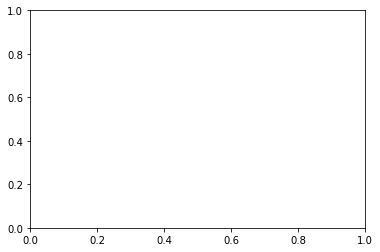

In [33]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_1)');